<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Metabo2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fundus_metabolic**

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Mount Google Drive if the CSV is in your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**元データの分析**

In [ ]:
# Load the CSV file (adjust the path if necessary)
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'  # Adjust this to your actual file path
data = pd.read_csv(file_path)

# Display basic statistics
print("Basic statistics of the dataset:")
print(data.describe())

# Drop non-numeric columns for correlation analysis
numeric_data = data.drop(columns=["filename"])

# Calculate and display the correlation matrix
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Gradient Boostingを使用

In [ ]:
####
# 他のデータからGradient Boostingを用いてMETSを予測すると、精度は99%以上とかなり高い
####

# Prepare the data for training (remove the filename and target column)
X = numeric_data.drop(columns=["METS"])
y = numeric_data["METS"]

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='accuracy')

# Display the cross-validation results
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

5-Fold Cross-Validation Accuracy Scores: [0.993 0.991 1.    1.    1.   ]
Mean Accuracy: 0.9968


In [ ]:
#########
# 重要なTOP3指標を抜き出してみる --> AC（腹囲), TG（中性脂肪）, BS（空腹時血糖）
#########

# Train the Gradient Boosting model
gb_model.fit(X, y)

# Get feature importances from the Gradient Boosting model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances for Gradient Boosting:")
print(feature_importances)


Feature Importances for Gradient Boosting:
  Feature  Importance
1      AC    0.432137
5      TG    0.242165
6      BS    0.147832
2     SBP    0.093333
4    HDLC    0.046051
3     DBP    0.038421
0     age    0.000062


In [ ]:
# このスクリプトは、メタボリックシンドローム（METS）の予測のために
# 各健康指標のカットオフ値を決定し、それに基づいてデータを2値化します。
#
# 主な手順：
# 1. Google Driveからデータを読み込む
# 2. 各健康指標（年齢、腹囲、血圧など）に対して以下の処理を行う：
#    a. ROC曲線を計算（HDLCの場合は値を反転）
#    b. Youden index（感度+特異度-1）を計算
#    c. Youden indexが最大となるポイントをカットオフ値として決定
#    d. カットオフ値を基準にデータを2値化（HDLCは逆基準）
# 3. 各指標のROC曲線をプロット
# 4. 結果（カットオフ値、感度、特異度、Youden index、高低の症例数）を表示
# 5. Youden indexの比較グラフを作成
# 6. カットオフ値周りの症例分布を棒グラフで表示
# 7. 2値化したデータを新しいデータフレームとして作成（filename, METSを含む）
# 8. 2値化したデータをCSVファイルとして保存
#
# 注意点：
# - HDLCは他の指標と逆の関係（高いほど良い）であるため、特別な処理を行っています。
# - 2値化の基準は、カットオフ値より大きい場合を1、それ以外を0としています（HDLCは逆）。
# - 結果のCSVファイルは元のファイルと同じディレクトリに保存されます。
# - filenameとMETSは元のデータからそのまま引き継がれます。

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Google Driveからデータの読み込み
data = pd.read_csv('/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv')

# 分析対象の列
features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']

# 結果を格納するリスト
results_list = []

# 2値化したデータを格納するデータフレーム
binary_data = pd.DataFrame()

# filenameとMETSを追加
binary_data['filename'] = data['filename']
binary_data['METS'] = data['METS']

# 各特徴量に対して解析を行う
for feature in features:
    # HDLCの場合は値を反転させる（高値が望ましいため）
    if feature == 'HDLC':
        feature_values = -data[feature]
    else:
        feature_values = data[feature]

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(data['METS'], feature_values)

    # Youden indexの計算
    youden_index = tpr - fpr

    # 最適なカットオフ値の決定
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]

    # HDLCの場合はカットオフ値を元の尺度に戻す
    if feature == 'HDLC':
        optimal_threshold = -optimal_threshold
        # HDLCの場合、"高い"と"低い"の意味が逆になる
        high_count = (data[feature] <= optimal_threshold).sum()
        low_count = (data[feature] > optimal_threshold).sum()
        # 2値化（HDLCは逆の基準で2値化）
        binary_data[f'{feature}_binary'] = (data[feature] <= optimal_threshold).astype(int)
    else:
        high_count = (data[feature] > optimal_threshold).sum()
        low_count = (data[feature] <= optimal_threshold).sum()
        # 2値化
        binary_data[f'{feature}_binary'] = (data[feature] > optimal_threshold).astype(int)

    # 結果の保存
    results_list.append({
        'Feature': feature,
        'Cutoff': optimal_threshold,
        'Sensitivity': tpr[optimal_idx],
        'Specificity': 1 - fpr[optimal_idx],
        'Youden Index': youden_index[optimal_idx],
        'High Count': high_count,
        'Low Count': low_count
    })

    # # ROC曲線のプロット
    # plt.figure(figsize=(8, 6))
    # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(data["METS"], feature_values):.2f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve for {feature}')
    # plt.legend(loc="lower right")
    # plt.show()

# 結果をデータフレームに変換
results = pd.DataFrame(results_list)

# 結果の表示
print(results.to_string(index=False))

# # 結果のプロット
# plt.figure(figsize=(10, 6))
# plt.bar(results['Feature'], results['Youden Index'])
# plt.title('Youden Index for Each Feature')
# plt.xlabel('Feature')
# plt.ylabel('Youden Index')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 症例数の比較プロット
# plt.figure(figsize=(12, 6))
# x = np.arange(len(features))
# width = 0.35
# plt.bar(x - width/2, results['High Count'], width, label='High')
# plt.bar(x + width/2, results['Low Count'], width, label='Low')
# plt.xlabel('Features')
# plt.ylabel('Count')
# plt.title('Distribution of Cases Around Cutoff')
# plt.xticks(x, features, rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

# 2値化したデータフレームの先頭数行を表示
print("\n2値化したデータフレーム（先頭10行）:")
print(binary_data.head(10))

# 2値化したデータフレームをCSVファイルとして保存
binary_data.to_csv('/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv', index=False)
print("\n2値化したデータをCSVファイルとして保存しました: '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv'")

Feature  Cutoff  Sensitivity  Specificity  Youden Index  High Count  Low Count
    age    46.0       0.6972       0.5200        0.2172        2781       2219
     AC    85.5       0.9844       0.6468        0.6312        3320       1680
    SBP   130.0       0.8644       0.7040        0.5684        2715       2285
    DBP    80.0       0.8212       0.6432        0.4644        2788       2212
   HDLC    55.0       0.7648       0.5624        0.3272        3006       1994
     TG   150.0       0.8316       0.8332        0.6648        2464       2536
     BS    94.0       0.5088       0.8220        0.3308        1604       3396

2値化したデータフレーム（先頭10行）:
                filename  METS  age_binary  AC_binary  SBP_binary  DBP_binary  \
0  img75151275_00_1R.jpg     1           1          1           1           1   
1  img96940480_00_1R.jpg     0           1          0           1           1   
2  img15900654_00_1R.jpg     1           1          1           0           1   
3  img74960801_00_1R.j

### NGBoostを使用

In [ ]:
#####
# あとでCNNと合体することを想定し、NGBoostを使う
#####
!pip install ngboost
from ngboost import NGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# Prepare the data for training (remove the filename and target column)
X = numeric_data.drop(columns=["METS"])
y = numeric_data["METS"]

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'minibatch_frac': [1.0, 0.8, 0.6],
    'col_sample': [1.0, 0.8, 0.6],
}

# Initialize the NGBoost model
ngb_model = NGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=ngb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Perform 5-fold cross-validation with the best model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Display the results
print("Best Parameters:", best_params)
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

[iter 0] loss=0.6931 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0206 val_loss=0.0000 scale=1.0000 norm=1.0232
[iter 0] loss=0.6909 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0149 val_loss=0.0000 scale=1.0000 norm=1.0166
[iter 0] loss=0.6924 val_loss=0.0000 scale=16.0000 norm=32.0000
[iter 100] loss=0.0160 val_loss=0.0000 scale=0.2500 norm=0.2544
[iter 0] loss=0.6928 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0178 val_loss=0.0000 scale=0.2500 norm=0.2549
[iter 0] loss=0.6929 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0205 val_loss=0.0000 scale=0.5000 norm=0.5115
[iter 0] loss=0.6869 val_loss=0.0000 scale=16.0000 norm=32.0000
[iter 100] loss=0.0216 val_loss=0.0000 scale=0.0625 norm=0.0640
Best Parameters: {'col_sample': 0.8, 'learning_rate': 0.05, 'minibatch_frac': 1.0, 'n_estimators': 200}
5-Fold Cross-Validation Accuracy Scores: [1.    0.996 1.    1.    1.   ]
Mean Accuracy: 0.9992000000000001
Standard Deviation: 0.001

In [ ]:
## NGBooostを用いた場合の関連因子

from ngboost import NGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
X = numeric_data.drop(columns=["METS"])
y = numeric_data["METS"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with the best parameters
best_model = NGBClassifier(col_sample=0.8, learning_rate=0.05, minibatch_frac=1.0, n_estimators=200, random_state=42)
best_model.fit(X_train, y_train)

# Perform permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': result.importances_mean})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Display the top 10 most important features
print("Top 10 most important features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
### TOP3だけで予測すると物足りない
# Select only the top 3 features: AC, TG, BS
X_top3 = data[['AC', 'TG', 'BS']]

# Perform 5-fold cross-validation using only these 3 features with Gradient Boosting
cv_scores_top3 = cross_val_score(gb_model, X_top3, y, cv=5, scoring='accuracy')

# Display the cross-validation results
cv_scores_top3, cv_scores_top3.mean()


(array([0.939, 0.918, 0.951, 0.945, 0.932]), 0.9369999999999999)

In [ ]:
### TOP1の腹囲をDropしてもそれなりに結果は良い
# Drop the AC feature
X_drop_AC = data.drop(columns=["filename", "METS", "AC"])

# Perform 5-fold cross-validation without AC using Gradient Boosting
cv_scores_drop_AC = cross_val_score(gb_model, X_drop_AC, y, cv=5, scoring='accuracy')

# Display the cross-validation results
cv_scores_drop_AC, cv_scores_drop_AC.mean()


(array([0.947, 0.945, 0.956, 0.955, 0.614]), 0.8834)

In [ ]:
#####################
## binary dataを用いたlogistic線形回帰
####################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# CSVの読み込み
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv'
df = pd.read_csv(file_path)

# 特徴量とターゲット変数を定義
X = df[['age_binary', 'AC_binary', 'SBP_binary', 'DBP_binary', 'HDLC_binary', 'TG_binary', 'BS_binary']]
y = df['METS']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ロジスティック回帰モデルの初期化
log_model = LogisticRegression()

# モデルを訓練データでフィッティング
log_model.fit(X_train, y_train)

# テストデータで予測
y_pred = log_model.predict(X_test)

# 精度の計算
accuracy = accuracy_score(y_test, y_pred)

# 5-Fold Cross-Validation
cv_scores = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')

# 結果を表示
print(f"Test Accuracy: {accuracy}")
print(f"5-Fold Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation: {cv_scores.std()}")


Test Accuracy: 0.888
5-Fold Cross-Validation Accuracy Scores: [0.815 0.874 0.895 0.918 0.879]
Mean Accuracy: 0.8762000000000001
Standard Deviation: 0.03423098012035299


In [ ]:
#####################
## binary dataを用いたngboost回帰（線形とあまり変わらないが）
####################

!pip install ngboost --q
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from ngboost import NGBClassifier

# CSVの読み込み
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv'
df = pd.read_csv(file_path)

# 特徴量とターゲット変数を定義
X = df[['age_binary', 'AC_binary', 'SBP_binary', 'DBP_binary', 'HDLC_binary', 'TG_binary', 'BS_binary']]
y = df['METS']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NGBoostモデルの初期化
ngb = NGBClassifier()

# パラメータグリッドの定義
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'minibatch_frac': [1.0, 0.8, 0.6],
    'col_sample': [1.0, 0.8, 0.6],
}

# GridSearchCVのセットアップ (途中経過の表示に verbose=3 を使用)
grid_search = GridSearchCV(estimator=ngb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)

# トレーニングデータに対してグリッドサーチを実行
grid_search.fit(X_train, y_train)

# 最適なパラメータを取得
best_params = grid_search.best_params_

# 最適パラメータでテストデータに対して予測を行う
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 精度の計算
accuracy = accuracy_score(y_test, y_pred)

# 結果を表示
print(f"Best parameters: {best_params}")
print(f"Accuracy with best parameters: {accuracy}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2016 val_loss=0.0000 scale=1.0000 norm=1.3211
Best parameters: {'col_sample': 0.8, 'learning_rate': 0.01, 'minibatch_frac': 0.8, 'n_estimators': 200}
Accuracy with best parameters: 0.929


#**Strategy**

1. 単純にbinaryでend-to-endする

2. 各項目を別個に数値として回帰させて、gradient boostingで予測

3. Multiple instance learning?

#**気がついたこと**

1. 病気の眼が混ざっている: DR, 黄斑上膜, 硝子体混濁, 白内障など。精度向上のため、Trainsetからは眼底が見えない症例は除外する。Testsetでも眼底が写っていない写真が3つぐらいあるが、これらの扱いについては後ほど考える。

2. 今回はすべて右眼である

3. 近視度数や白内障による白濁など、眼底の色が様々である。これらの情報はそれなりに役立ちそうなので、推測する項目によっては残しておいた方が良いような気がする。




#**Image Preprocessing**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_1/img00032465_00_1R.jpg"

img = cv2.imread(img_path)
cv2_imshow(img)

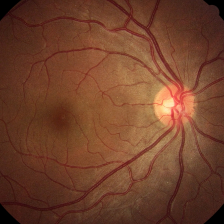

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def crop_center_image(cv2_img, crop_size=900):
    # 画像のサイズを取得
    height, width, _ = cv2_img.shape

    # 中心座標を計算
    center_x = width // 2
    center_y = height // 2

    # 切り抜きの開始座標を計算
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2

    # 画像の切り抜き
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]

    return cropped_img

def resize_image(cv2_img, size=(224, 224)):
    # リサイズ
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 使用例
img = cv2.imread(img_path)  # 画像パスに合わせて指定
cropped_img = crop_center_image(img)  # 900x900pxで切り抜き
resized_img = resize_image(cropped_img)  # 224x224pxにリサイズ

# 切り抜いてリサイズした画像の表示
cv2_imshow(resized_img)


###**トレーニング画像を縮小**

In [ ]:
"""
画像リサイズスクリプト

このスクリプトは、指定された複数のディレクトリから全ての画像を読み込み、
以下の処理を行います：
1. 画像の中央部分を900x900ピクセルで切り抜き
2. 切り抜いた画像を224x224ピクセルにリサイズ
3. 処理した画像を新しい出力ディレクトリに保存

主な機能：
- 複数の入力ディレクトリから全ての画像を読み込む
- 画像の中央部分を切り抜く（crop_center_image関数）
- 画像をリサイズする（resize_image関数）
- 処理済み画像を新しいディレクトリに保存
- 詳細な進捗状況の表示

注意：
- 対応している画像形式は.png、.jpg、.jpegです
- Google Colab環境での実行を想定しています
"""

import os
import cv2
from tqdm import tqdm

def crop_center_image(cv2_img, crop_size=900):
    height, width, _ = cv2_img.shape
    center_x = width // 2
    center_y = height // 2
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    return cropped_img

def resize_image(cv2_img, size=(224, 224)):
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 入力ディレクトリと出力ディレクトリの設定
input_dirs = [f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_{i}" for i in range(1, 11)]
output_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 全画像ファイルのリストを作成
all_image_files = []
for input_dir in input_dirs:
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_image_files.extend([(input_dir, f) for f in image_files])

# 進捗バーの設定
total_images = len(all_image_files)
pbar = tqdm(total=total_images, desc="画像処理", unit="枚")

# 全ての画像を処理
for input_dir, filename in all_image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 画像の読み込み、クロップ、リサイズ
    img = cv2.imread(input_path)
    cropped_img = crop_center_image(img)
    resized_img = resize_image(cropped_img)

    # 処理した画像を保存
    cv2.imwrite(output_path, resized_img)

    # 進捗バーの更新
    pbar.update(1)

# 進捗バーの終了
pbar.close()

print(f"\n処理完了: 合計 {total_images} 枚の画像を処理しました。")

#**simple classification**

まずは、中央を900x900で切り抜いた後に224x224に縮小した画像でbinaryな分類を試みる

In [ ]:
!pip install timm

In [ ]:
#試してみるモデル
#ResNet50 --> 60%ぐらいが限界
#EfficitnetNetv2 --> 60%
#RepVGGA0 --> 60%弱

model.safetensors:   0%|          | 0.00/36.6M [00:00<?, ?B/s]

Epoch 1/50
Train Loss: 0.7039, Train Acc: 0.5507
Val Loss: 0.6803, Val Acc: 0.5620
Epoch duration: 46.26 seconds
----------------------------------------
Epoch 2/50
Train Loss: 0.6878, Train Acc: 0.5527
Val Loss: 0.6806, Val Acc: 0.5730
Epoch duration: 43.42 seconds
----------------------------------------
Epoch 3/50
Train Loss: 0.6806, Train Acc: 0.5795
Val Loss: 0.6801, Val Acc: 0.5670
Epoch duration: 43.12 seconds
----------------------------------------
Epoch 4/50
Train Loss: 0.6811, Train Acc: 0.5700
Val Loss: 0.6811, Val Acc: 0.5710
Epoch duration: 42.78 seconds
----------------------------------------
Epoch 5/50
Train Loss: 0.6781, Train Acc: 0.5760
Val Loss: 0.6834, Val Acc: 0.5430
Epoch duration: 43.03 seconds
----------------------------------------
Epoch 6/50
Train Loss: 0.6742, Train Acc: 0.5870
Val Loss: 0.6770, Val Acc: 0.5750
Epoch duration: 42.71 seconds
----------------------------------------
Epoch 7/50
Train Loss: 0.6700, Train Acc: 0.5952
Val Loss: 0.6602, Val Acc: 

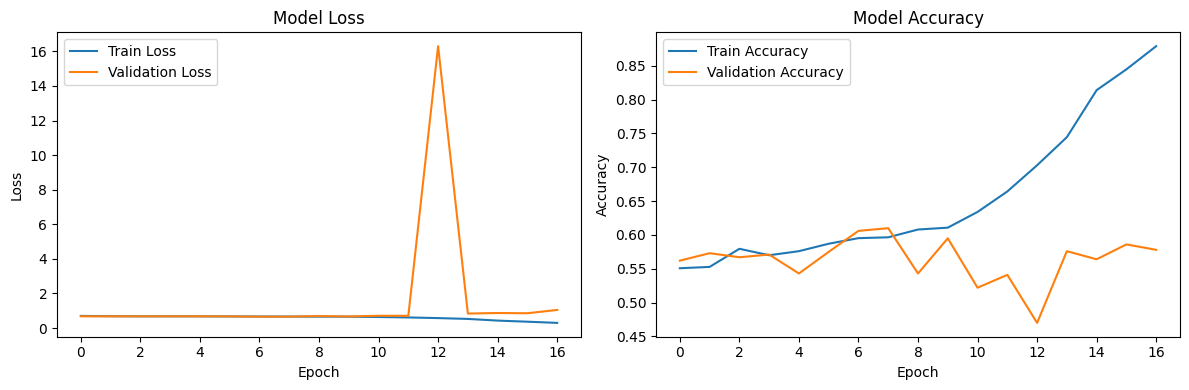

In [ ]:
# 眼底画像を用いた代謝症候群分類モデル（エラー修正版）
#
# このスクリプトは以下の機能を実装しています：
# 1. 眼底画像データセットの読み込みと前処理
# 2. データ拡張（Image Augmentation）の適用（Torchvision最新版に対応）
# 3. ResNet50を用いた転移学習モデルの構築
# 4. モデルのトレーニングと評価（各エポックの実行時間を表示）
# 5. Early Stoppingの実装
# 6. 最終的な性能評価とレポート生成
# 7. トレーニング過程の可視化
# 8. 総実行時間の表示

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
import time
import random

# Training settings
num_epochs = 50
patience = 10
seed = 42


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

full_dataset = FundusDataset(csv_file, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# モデルの定義
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 2)  # 2クラス分類

    def forward(self, x):
        return self.resnet(x)


class EfficientNetV2s(nn.Module):
    def __init__(self):
        super(EfficientNetV2s, self).__init__()
        self.efficientnet = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.efficientnet.get_classifier().in_features

        # Replace the classifier with a new one for 2-class classification
        self.efficientnet.classifier = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.efficientnet(x)


class CoAtNet2(nn.Module):
    def __init__(self):
        super(CoAtNet2, self).__init__()
        self.coatnet = timm.create_model('coatnet_2_rw_224.sw_in12k_ft_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.coatnet.head.fc.in_features

        # Replace the classifier with a new one for 2-class classification
        self.coatnet.head.fc = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.coatnet(x)

class RepVGGA0(nn.Module):
    def __init__(self):
        super(RepVGGA0, self).__init__()
        self.repvgg = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.repvgg.head.fc.in_features

        # Replace the classifier with a new one for 2-class classification
        self.repvgg.head.fc = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.repvgg(x)

class RepViTM1_0(nn.Module):
    def __init__(self, num_classes=2):
        super(RepViTM1_0, self).__init__()
        self.repvit = timm.create_model('repvit_m1_0.dist_450e_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.repvit.head.head.l.in_features

        # Replace the classifier with a new one for num_classes classification
        self.repvit.head.head.l = nn.Linear(in_features, num_classes)
        self.repvit.head.head_dist.l = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.repvit(x)



# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = ResNet50Model().to(device)
#model = EfficientNetV2s().to(device)
#model = CoAtNet2().to(device)
#model = RepVGGA0().to(device)
#model = RepViTM1_0().to(device)
#model = timm.create_model('swin_base_patch4_window7_224_in22k', pretrained=True, num_classes=2).to(device)
#model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2).to(device)
model = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002)

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# トレーニングループ
num_epochs = num_epochs
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print("-" * 40)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

end_time = time.time()
total_duration = end_time - start_time

print(f"Total training time: {total_duration:.2f} seconds")



# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = timm.create_model('repvit_m1_0.dist_450e_in1k', pretrained=True)
print(model)

###**Small datasetを用いたテスト**

In [ ]:
# 眼底画像を用いたメタボ分類
#
# このスクリプトは、眼底画像を使用して代謝症候群の二値分類を行います。
# 事前学習済みのResNet50モデルを使用し、300画像の縮小データセットで微調整を行います。
#
# 主要コンポーネント:
# 1. データ準備:
#    - 元のデータセットを300サンプルに縮小
#    - トレーニングセットと検証セットに分割
# 2. モデル:
#    - timmライブラリから事前学習済みResNet50モデルを使用
#    - 最終の全結合層を二値分類用に変更
# 3. トレーニング:
#    - カスタムトレーニングループとEarly Stoppingを実装
#    - Adamオプティマイザとクロスエントロピー損失を使用
# 4. 評価:
#    - 検証セットで最終評価を実施
#    - 精度と分類レポートを出力
# 5. 可視化:
#    - トレーニングと検証の損失/精度曲線をプロット
#
# 注意: このバージョンは、迅速なテストと反復のために縮小されたデータセットを使用しています。
#       必要に応じて、データセットのサイズ、モデルのパラメータ、トレーニング設定を調整してください。

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# CSVファイルを読み込み、最初の300行を抽出
full_data = pd.read_csv(csv_file)
reduced_data = full_data.head(300)
reduced_csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train_reduced.csv"
reduced_data.to_csv(reduced_csv_file, index=False)

# 縮小されたデータセットを使用
dataset = FundusDataset(reduced_csv_file, img_dir, transform=transform)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

print(f"Total samples in reduced dataset: {len(dataset)}")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# モデルの定義
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 2)  # 2クラス分類

    def forward(self, x):
        return self.resnet(x)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# トレーニングループ
num_epochs = 50
early_stopping = EarlyStopping(patience=10)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 40)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

#**周辺項目から攻めるバージョン**


-----------
###説明変数

age: 年齢

AC: 腹囲

SBP: 収縮期血圧

DBP: 拡張期血圧

HDLC: HDLコレステロール

TG: 中性脂肪

BS: 血糖

---------------

###目的変数

METS: メタボリックシンドロームの有無

---------------

1. label_train.csvから標準化した説明変数をピックアップする

2. ResNet50で、7つの説明変数を同時に回帰するモデルを作成する。Lossは最小二乗誤差とする

3. まずはこのモデルがうまく作成できるかを検討

4. ある程度モデルの精度が上がったら、7つの変数からNGBoostを用いてMETsを予測するモデルを結合して、METsを目的変数としてファインチューニングする


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
!pip install ranger-adabelief==0.1.0
from ranger_adabelief import RangerAdaBelief

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # 説明変数の標準化
        self.scaler = StandardScaler()
        self.features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
        self.data[self.features] = self.scaler.fit_transform(self.data[self.features])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # 説明変数を取得
        features = self.data.iloc[idx][self.features].values.astype(np.float32)

        # METSラベルを取得
        mets_label = self.data.iloc[idx]['METS']

        if self.transform:
            image = self.transform(image)

        return image, features, mets_label

# データの前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

full_dataset = FundusDataset(csv_file, img_dir, transform=transform)
train_dataset, val_dataset = train_test_split(full_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# マルチ出力回帰モデルの定義
# class MultiOutputRegression(nn.Module):
#     def __init__(self):
#         super(MultiOutputRegression, self).__init__()
#         self.resnet = timm.create_model('resnet50', pretrained=True)
#         in_features = self.resnet.fc.in_features
#         self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

#         self.regression_head = nn.Sequential(
#             nn.Linear(in_features, 256),
#             nn.ReLU(),
#             nn.Linear(256, 7)  # 7 outputs for regression
#         )

#     def forward(self, x):
#         features = self.resnet(x)
#         return self.regression_head(features)

class MultiOutputRegression(nn.Module):
    def __init__(self):
        super(MultiOutputRegression, self).__init__()
        self.repvgg = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True)
        in_features = self.repvgg.head.fc.in_features
        self.repvgg.head.fc = nn.Identity()  # Remove the final fully connected layer

        self.regression_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 7)  # 7 outputs for regression
        )

    def forward(self, x):
        features = self.repvgg(x)
        return self.regression_head(features)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiOutputRegression().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0002)
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), weight_decouple = True)


# トレーニングループ
num_epochs = 50
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, features, _ in train_loader:
        images, features = images.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, features)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, features, _ in val_loader:
            images, features = images.to(device), features.to(device)
            outputs = model(images)
            loss = criterion(outputs, features)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# モデルの評価
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for images, features, _ in val_loader:
        images, features = images.to(device), features.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(features.cpu().numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

# R-squared score for each feature
from sklearn.metrics import r2_score

feature_names = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
for i, feature in enumerate(feature_names):
    r2 = r2_score(all_true[:, i], all_preds[:, i])
    print(f"R-squared score for {feature}: {r2:.4f}")

# Scatter plots for each feature
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    axes[i].scatter(all_true[:, i], all_preds[:, i], alpha=0.5)
    axes[i].plot([all_true[:, i].min(), all_true[:, i].max()], [all_true[:, i].min(), all_true[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel(f'True {feature}')
    axes[i].set_ylabel(f'Predicted {feature}')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

In [ ]:
# 必要なライブラリのインストール
!pip install timm
!pip install ranger-adabelief==0.1.0

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
from ranger_adabelief import RangerAdaBelief

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # 説明変数の標準化
        self.scaler = StandardScaler()
        self.features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
        self.data[self.features] = self.scaler.fit_transform(self.data[self.features])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # 説明変数を取得
        features = self.data.iloc[idx][self.features].values.astype(np.float32)

        # METSラベルを取得
        mets_label = self.data.iloc[idx]['METS']

        if self.transform:
            image = self.transform(image)

        return image, features, mets_label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

full_dataset = FundusDataset(csv_file, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# RepVGG A0を使用したマルチ出力回帰モデルの定義
class MultiOutputRegression(nn.Module):
    def __init__(self):
        super(MultiOutputRegression, self).__init__()
        self.repvgg = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True)
        in_features = self.repvgg.head.fc.in_features
        self.repvgg.head.fc = nn.Identity()  # Remove the final fully connected layer

        self.regression_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 7)  # 7 outputs for regression
        )

    def forward(self, x):
        features = self.repvgg(x)
        return self.regression_head(features)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiOutputRegression().to(device)
criterion = nn.MSELoss()
optimizer = RangerAdaBelief(model.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), weight_decouple=True)

# トレーニングループ
num_epochs = 50
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, features, _ in train_loader:
        images, features = images.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, features)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, features, _ in val_loader:
            images, features = images.to(device), features.to(device)
            outputs = model(images)
            loss = criterion(outputs, features)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# モデルの評価
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for images, features, _ in val_loader:
        images, features = images.to(device), features.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(features.cpu().numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

# R-squared score for each feature
from sklearn.metrics import r2_score

feature_names = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
for i, feature in enumerate(feature_names):
    r2 = r2_score(all_true[:, i], all_preds[:, i])
    print(f"R-squared score for {feature}: {r2:.4f}")

# Scatter plots for each feature
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    axes[i].scatter(all_true[:, i], all_preds[:, i], alpha=0.5)
    axes[i].plot([all_true[:, i].min(), all_true[:, i].max()], [all_true[:, i].min(), all_true[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel(f'True {feature}')
    axes[i].set_ylabel(f'Predicted {feature}')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/repvgg_regression_model.pth')
print("Model saved successfully.")